# Lesson 06. Introduction to Patterns in Multivariate Data

## Introduction
In this exercise, we will explore how Principal Component Analysis (PCA) — also known in climate science as Empirical Orthogonal Function (EOF) analysis — can be used to uncover dominant patterns of variability in sea surface temperature (SST).

Using the Extended Reconstructed Sea Surface Temperature (ERSSTv6) dataset, we will:

1. Compute SST anomalies relative to a climatological baseline.
2. Construct the Niño 3.4 Index, a widely used measure of the El Niño–Southern Oscillation (ENSO).
3. Apply PCA to the tropical Pacific SST field and interpret the resulting modes (EOFs and PCs).

By the end of this lesson, we should be able to:
- Describe how PCA decomposes a large spatiotemporal dataset into spatial patterns and temporal modes.
- Recognize the seasonal cycle and ENSO as the first two leading EOFs of tropical Pacific SST.
- Compare a physically defined ENSO index (Niño 3.4) with a statistically derived one (PC 2).


#### Acknowledgements and AI Disclaimer 
This lesson was adapted from the [Karen L. Smith](https://kls2177.github.io/)'s book on [Climate and Geophysical Data Analysis](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/index.html), in particular, the chapter on [Patterns in Multivariate Data](https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week7/pca.html). Data for this lecture is downloaded and complied from [NOAA's Extended Reconstructed Sea Surface Temperature (ERSST)](https://www.ncei.noaa.gov/products/extended-reconstructed-sst). 

A set of [downloader](preprocessor_download-sst.sh) and [combiner scripts](preprocessor_combine-nc.ipynb) are provided in this repository. For your convenience, I have compiled the data (1950-2024) [in this link](https://drive.google.com/file/d/1GIY4GuzoVK7qTlhfMywEMS7ghmywiJ_7/view?usp=sharing). Download this and store the data in the same folder as this notebook.

The material has been updated and restructured for Meteo 203 (Methods of Analytical Meteorology & Oceanography) with the assistance of ChatGPT for code modernization, annotation, and formatting.

All scientific content, computations, and instructional revisions have been reviewed and verified by BBR.

In [1]:
# in case packages haven't been installed, uncomment the snippet below, and run the cell.
!conda install -c conda-forge h5py xarray netCDF4 --name meteo203 -y

Jupyter detected...
3 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.



In [2]:
# Imports
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.geodesic import Geodesic
from shapely.geometry import box


C:\Users\alexg\miniconda3\envs\meteo203\lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


---

### Part 1. Open the data using xarray

In [4]:
file_path = 'ersst.v6.195001_202412.nc'
ds = xr.open_dataset(file_path)

#### Inspect the data

In [5]:
ds

<xarray.Dataset> Size: 115MB
Dimensions:  (time: 900, lev: 1, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lev      (lev) float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-12-15
Data variables:
    sst      (time, lev, lat, lon) float32 58MB ...
    ssta     (time, lev, lat, lon) float32 58MB ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    metadata_link:                   gov.noaa.ncei:C01737
    id:                              ersst.v6.195001.nc
    naming_authority:                gov.noaa.ncei
    title:                           NOAA monthly ERSSTv6 (in situ only)
    summary:                         Monthly ERSSTv6 is developed based on v5...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    references:                      Huang, B., X. Yin, T. Boyer, C. Liu, M. ...
    climatology:                     Climatology is based on 1991-2020 SST of...
    acknowledgment:                  The NOAA Extended Reconstructed Sea Surf...
    NCO:                             netCDF Operators version 5.0.7 (Homepage...
    history:                         Fri May  2 14:08:56 2025: ncap2 -O -s ti...

We'll be selecting `sst` data for the first level using the snippet below.

In [6]:
sst = ds['sst'].isel(lev=0)

In [7]:
sst

<xarray.DataArray 'sst' (time: 900, lat: 89, lon: 180)> Size: 58MB
[14418000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
    lev      float64 8B 0.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-12-15
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:      -3.0
    valid_max:      45.0

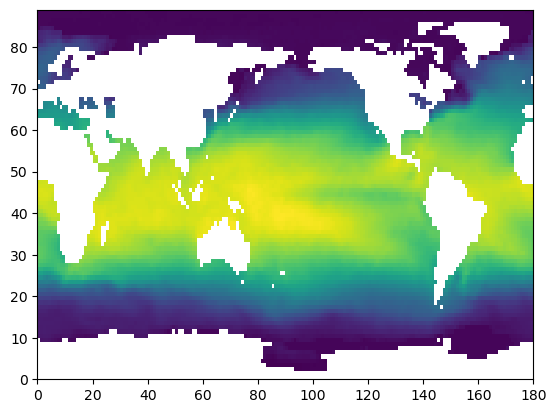

In [8]:
plt.pcolormesh(sst[0])

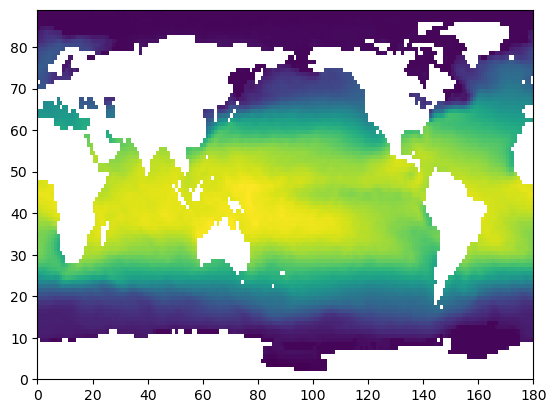

In [9]:
plt.pcolormesh(sst[1])

---

### Part 2. Calculate climatologies.

The data we have is for 1950 to 2024. Let's calculate for climatological normals from 1950 to 1979 by calculating the mean according to the `time` dimension. 

We first get the time period using `.sel(time=slice("1950", "1979"))`, and then the mean in the time axis using `.mean(dim="time")`. This can be done in one line as provided in the script below.

In [10]:
sst_clim = sst.sel(time=slice("1950", "1979")).mean(dim="time")

We can now plot the climatologies.

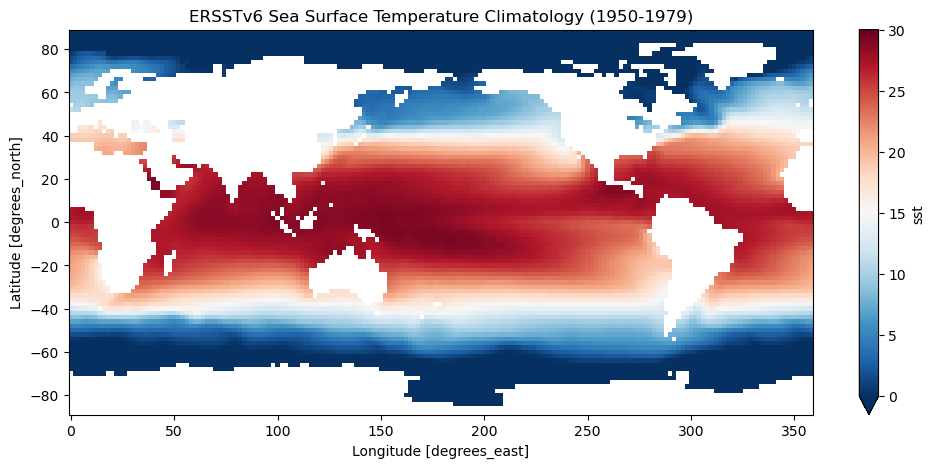

In [11]:
plt.figure(figsize=(12, 5))
sst_clim.plot(cmap='RdBu_r', vmin=0, vmax=30)
plt.title("ERSSTv6 Sea Surface Temperature Climatology (1950-1979)")
plt.show()


---
### Part 3. Calculate annual means.

The data is stored in monthly periods (`time: 900`). We can index and select according to month, or we can do this according to year. For this section let's slice according to year (`.sel(time="2024")`) giving us 12 months in a dataframe.  We can then proceed to calculate the annual mean, again according to `time`.

In [12]:
# Get the SST for one year, and then calculate the mean.
sst_2024 = sst.sel(time="2024").mean(dim='time')

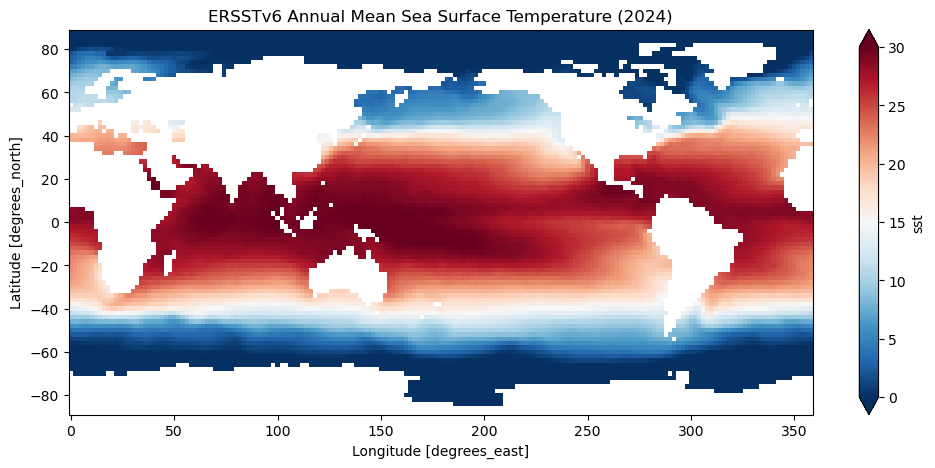

In [13]:
plt.figure(figsize=(12, 5))
sst_2024.plot(cmap='RdBu_r', vmin=0, vmax=30)
plt.title("ERSSTv6 Annual Mean Sea Surface Temperature (2024)")
plt.show()


---
### Part 4. Calculate anomalies.

By itself the annual means do not look much. By qualitative comparison, the two plots above look similar. To see the differences of a certain year compared to the climatology, we can calculate the *anomalies* by subtracting the climatology (1950-1979) from the annual mean. Notice how the colorbar is now centered on zero, depending on how we set the `vmin` and `vmax`.

In the map below, notice where the SST is warmer than the climatological normals. 

In [14]:
sst_anom_2024 = sst_2024 - sst_clim

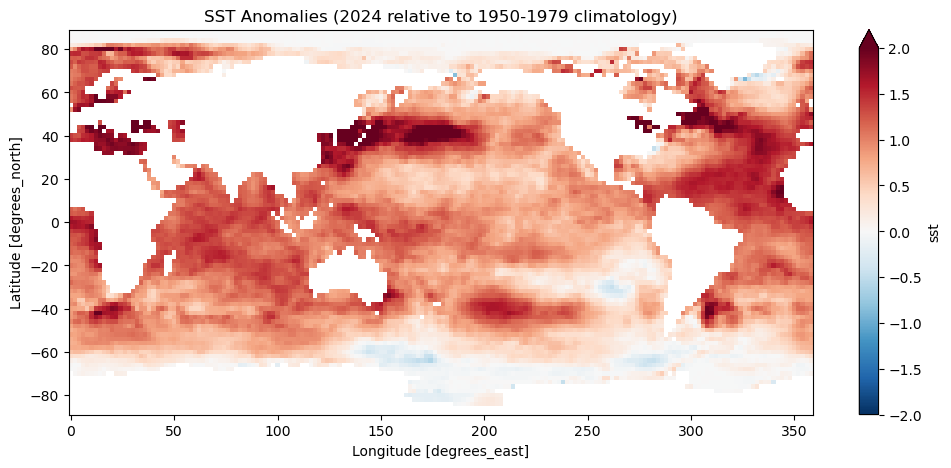

In [15]:
plt.figure(figsize=(12,5))
sst_anom_2024.plot(cmap='RdBu_r', vmin=-2, vmax=2)
plt.title("SST Anomalies (2024 relative to 1950-1979 climatology)")
plt.show()

---
### Part 5. Calculate anomalies for the 1997 ENSO onset.

The 1997-1998 ENSO was considered [one of the strongest on record](https://www.pmel.noaa.gov/pubs/outstand/mcph2029/text.shtml). Let's try to take a look at the annual SST anomalies for 1997.

First let's calculate and plot the annual average SSTs for 1997.

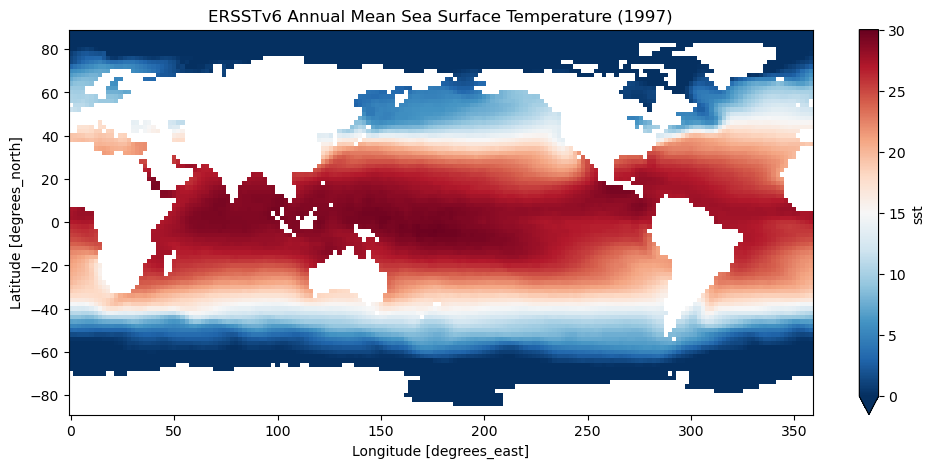

In [16]:
sst_1997 = sst.sel(time="1997").mean(dim='time')

plt.figure(figsize=(12, 5))
sst_1997.plot(cmap='RdBu_r', vmin=0, vmax=30)
plt.title("ERSSTv6 Annual Mean Sea Surface Temperature (1997)")
plt.show()


Now let's calculate for the anomalies and then plot. 

How does the map above (annual mean) compare with the map below (anomalies)? Notice the extension of the warm tongue in South America. 

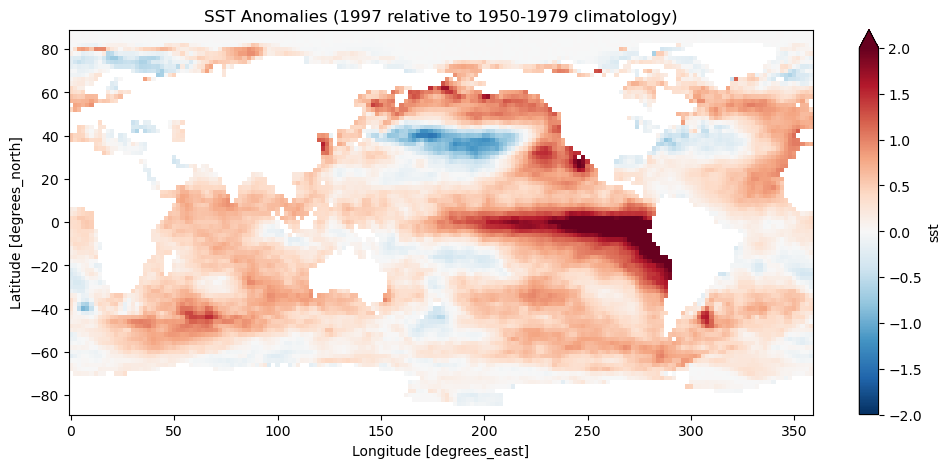

In [17]:
# Get the SST for one year
sst_anom_1997 = sst_1997 - sst_clim
plt.figure(figsize=(12,5))
sst_anom_1997.plot(cmap='RdBu_r', vmin=-2, vmax=2)
plt.title("SST Anomalies (1997 relative to 1950-1979 climatology)")
plt.show()

---
### Part 6. Plot in cartopy to contextualize

The maps above are simple array plots. We can plot them with cartopy so we have contextual information (i.e. country boundaries). 

Hint: try changing the `central_longitude` input, what happens?

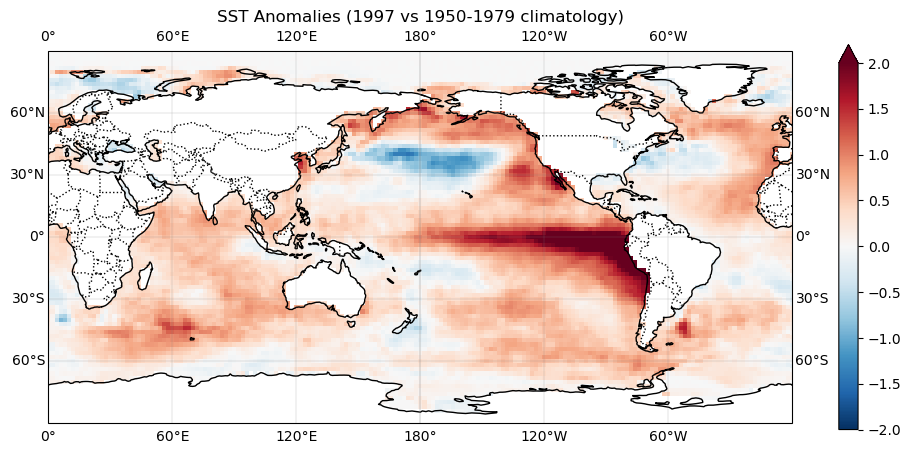

In [19]:

# Select and compute anomaly
sst_1997 = sst.sel(time="1997").mean(dim="time")
sst_anom_1997 = sst_1997 - sst_clim

# Set up figure with Cartopy
fig = plt.figure(figsize=(12,5))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)

# Add map features
ax.coastlines(resolution="110m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_global()
ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)

# Plot SST anomalies
pcm = sst_anom_1997.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-2, vmax=2,
    add_colorbar=True,
    add_labels=False
)

# Add title
plt.title("SST Anomalies (1997 vs 1950-1979 climatology)", fontsize=12)
plt.show()


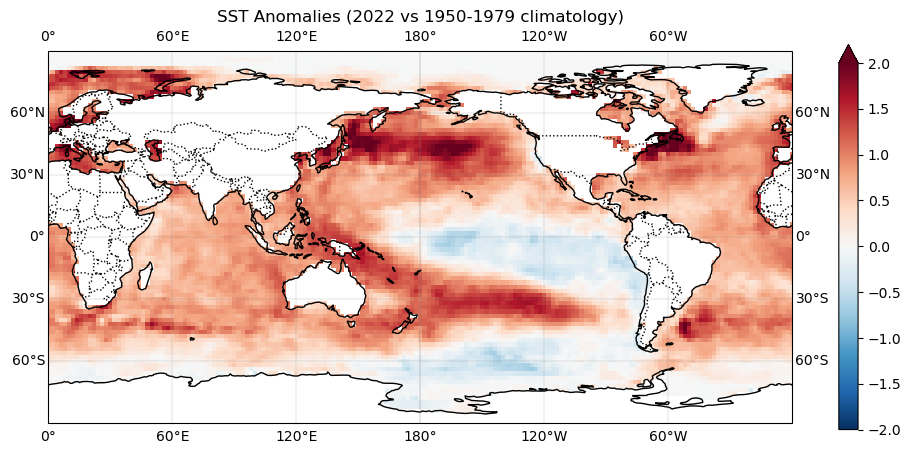

In [20]:

# Select and compute anomaly
sst_2022 = sst.sel(time="2022").mean(dim="time")
sst_anom_2022 = sst_2022 - sst_clim

# Set up figure with Cartopy
fig = plt.figure(figsize=(12,5))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)

# Add map features
ax.coastlines(resolution="110m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_global()
ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)

# Plot SST anomalies
pcm = sst_anom_2022.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-2, vmax=2,
    add_colorbar=True,
    add_labels=False
)

# Add title
plt.title("SST Anomalies (2022 vs 1950-1979 climatology)", fontsize=12)
plt.show()


---
### Part 7. Calculating the Niño3.4 Index.

In this sectopm we are going to construct the ENSO index. First, we will construct it following the [Niño 3.4 Index](http://www.cgd.ucar.edu/cas/catalog/climind/TNI_N34/index.html#Sec5) definition. The Niño3.4 Index is a commonly used metric of ENSO variability. The recipe for calculating it is:

1. Compute area averaged total SST from Niño3.4 region (5N-5S, 170W-120W).
2. Compute monthly climatology (1950-1979) for area averaged total SST from Niño 3.4 region
3. Subtract climatology from area averaged total SST time series to obtain anomalies.
4. Smooth the anomalies with a 5-month running mean.
5. Standardize the smoothed Niño3.4 by its standard deviation over the climatological period 1950-1979.

But first, let's plot the `sst_1997` maps from above along with the  Niño 3.4 boundaries. We can plot the [Niño 3.4 boundaries](https://www.ncei.noaa.gov/access/monitoring/enso/sst) using the `n34_box` variable and `add_geometries` in the script below. Since we have already calculated `sst_anom_1997` in a cell above, no need to recalculate here. 

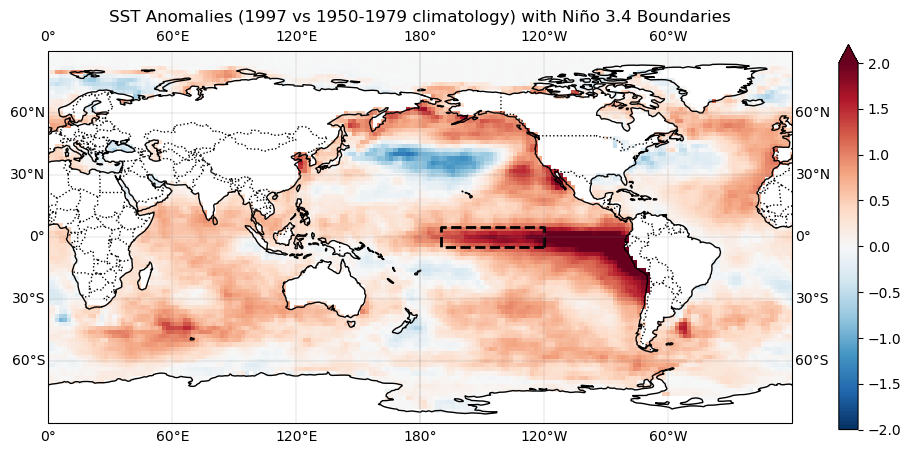

In [21]:
# Set up figure with Cartopy
fig = plt.figure(figsize=(12,5))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)

# Add map features
ax.coastlines(resolution="110m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_global()
ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)

# Plot SST anomalies
pcm = sst_anom_1997.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-2, vmax=2,
    add_colorbar=True,
    add_labels=False
)

# Define Nino 3.4 box boundaries
lon_min, lon_max = 190, 240   # 170°W–120°W in 0–360° convention
lat_min, lat_max = -5, 5

# Create a rectangular polygon
n34_box = box(lon_min, lat_min, lon_max, lat_max)

# Add it to the map
ax.add_geometries(
    [n34_box],
    crs=ccrs.PlateCarree(),
    facecolor="none",
    edgecolor="black",
    linewidth=2,
    linestyle="--"
)


# Add title
plt.title("SST Anomalies (1997 vs 1950-1979 climatology) with Niño 3.4 Boundaries", fontsize=12)
plt.show()


At this point let's now calculate the SST anomalies in the Niño 3.4 region. We can use xarray's [`sel`](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html) and then slice according to `lat` and `lon`.  Afterwards, we can take the mean for the sliced box using `.mean(dim=["lat, "lon"])`.

Notice in the script below we directly subtracted the slice from the climatology. If the xarray dataframe is constructed properly, the mathematical operations will respect the geography of the individual dataframes (i.e. we are subtracting from the same slices). 

In [22]:
# sst_1997_monthly = sst.sel(time="1997")
sst_anom_n34 = sst.sel(lat=slice(-5, 5), lon=slice(190, 240)) - sst_clim

# Take the mean over both lat and lon for each time step
nino34 = sst_anom_n34.mean(dim=["lat", "lon"])


At this point, `nino34` should be a time-series array of 900 timesteps. Question: what do these timesteps represent?

In [23]:
# print the nino34 dataframe
nino34

<xarray.DataArray 'sst' (time: 900)> Size: 4kB
array([-1.87606955e+00, -1.62472165e+00, -6.14652097e-01, -3.08662921e-01,
       -5.48828959e-01, -2.80171156e-01, -3.84788632e-01, -7.87027955e-01,
       -1.18145919e+00, -9.33042347e-01, -1.27565169e+00, -1.31048441e+00,
       -1.36282754e+00, -5.01755655e-01,  2.85784632e-01,  9.28062141e-01,
        1.05271268e+00,  9.93493915e-01,  9.33323145e-01,  6.04068100e-01,
        5.08274496e-01,  7.26257741e-01,  3.37875843e-01,  2.95789927e-01,
       -9.82142091e-02,  1.90984860e-01,  2.00007960e-01,  1.40469122e+00,
        7.16210008e-01, -1.68556571e-01, -3.85823250e-01, -3.86856198e-01,
       -4.80916023e-01, -2.71237254e-01, -6.54419184e-01, -9.37521875e-01,
        1.74737692e-01,  3.17975909e-01,  4.90739226e-01,  1.45948577e+00,
        1.50464678e+00,  1.50233841e+00,  6.78880453e-01,  1.12390429e-01,
        5.95256567e-01, -1.57062277e-01,  3.78851950e-01, -1.91643789e-01,
       -1.00839026e-01,  3.28590512e-01,  3.13861370e-01,  2.17478335e-01,
        4.21087176e-01,  7.62230232e-02, -4.60038573e-01, -1.24587762e+00,
       -1.44040835e+00, -7.44988203e-01, -8.90342832e-01, -1.08344257e+00,
       -9.36176002e-01, -6.74554050e-01, -3.37380618e-01,  8.58355016e-02,
       -2.57863909e-01, -7.14522135e-03, -8.95004630e-01, -8.76330018e-01,
       -1.64251924e+00, -2.03396130e+00, -2.16916823e+00, -2.08006930e+00,
       -1.74711335e+00, -7.40948439e-01, -2.38859579e-01,  2.01401830e-01,
        3.89495969e-01,  2.41962299e-01, -3.96073103e-01, -9.13344264e-01,
...
        4.44187820e-01,  9.50081408e-01,  1.08792841e+00,  9.45891201e-01,
        7.10911989e-01,  8.59824955e-01,  1.48144507e+00,  1.85010910e+00,
        1.93470335e+00,  1.62304211e+00,  9.90855515e-01,  3.15250278e-01,
        8.91896933e-02,  7.24566996e-01,  7.39195466e-01,  5.38214505e-01,
        5.65162539e-01,  5.56904256e-01,  1.08839273e+00,  1.63137794e+00,
        1.07325661e+00,  6.78701282e-01,  4.88604724e-01, -2.83285201e-01,
       -7.40807474e-01, -1.10883570e+00, -1.13180780e+00, -1.24382865e+00,
       -1.22021782e+00, -9.83289063e-01, -1.42014667e-01,  4.62980479e-01,
        7.73063600e-01,  8.28315616e-01,  2.23921627e-01, -3.26213598e-01,
       -5.26997268e-01, -8.72249067e-01, -8.75916719e-01, -1.14055610e+00,
       -8.12025011e-01, -6.11206055e-01, -1.23350218e-01,  2.77149469e-01,
        3.37396950e-01,  4.39392567e-01,  8.29707831e-02, -5.65759361e-01,
       -8.12818944e-01, -7.72917151e-01, -7.93420672e-01, -7.65412450e-01,
       -7.70369351e-01, -4.43679750e-01,  5.14545202e-01,  1.23093522e+00,
        1.67169583e+00,  1.81325054e+00,  1.54959905e+00,  1.46378243e+00,
        1.57494342e+00,  1.70559478e+00,  2.03580666e+00,  1.86645150e+00,
        1.70224404e+00,  1.53789413e+00,  1.62828672e+00,  2.00267458e+00,
        1.53491986e+00,  1.09871781e+00,  7.32432067e-01,  1.81862295e-01,
       -1.96818233e-01, -1.05732203e-01, -1.86309338e-01, -6.89393997e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-12-15
    lev      float64 8B 0.0

[The Niño 3.4 index typically uses a 5-month running mean](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni), and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more. Let's now calculate for the 5-month running mean using xarray's [`rolling`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html) windows, and then let's calculate the `.mean()`.

In [24]:
# Apply 5-month centered rolling mean
nino34_smooth = nino34.rolling(time=5, center=True).mean()


Since the data spans many years (1950-1979), we need to first normalize and then  standardize; in our lecture, we called this the *standardized anomalies*. For the `base_period` 1950 to 1979, let's first calculate the mean for the period (`mean_base`), and then the standard deviation (`std_base`). Afterwards, let's calculate the standardized anomalies by subtracting the mean from the smoothed data, and then dividing by the standard deviation for the base period.

In [25]:
# Compute mean and std from baseline (1950–1979)
base_period = slice("1950", "1979")
mean_base = nino34_smooth.sel(time=base_period).mean()
std_base  = nino34_smooth.sel(time=base_period).std()

# Standardize
nino34_std = (nino34_smooth - mean_base) / std_base


At this point we can plot the `nino34_std`, which is the standardized anomalies for the 5-month running mean. [The Oceanic Niño Index or ONI](https://www.ncei.noaa.gov/access/monitoring/enso/sst#oni) defines warm and cold phases as a minimum of five consecutive 3-month running averages of SST anomalies in the Niño 3.4 region surpassing a threshold of +/- 0.5°C, respectively. 

We can plot these thresholds using matplotlib's [`axhline`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html). We can also color the under the time-series whenever they exceed 0 in the positive or negative using [`fill_between`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html). All of this code is provided below.

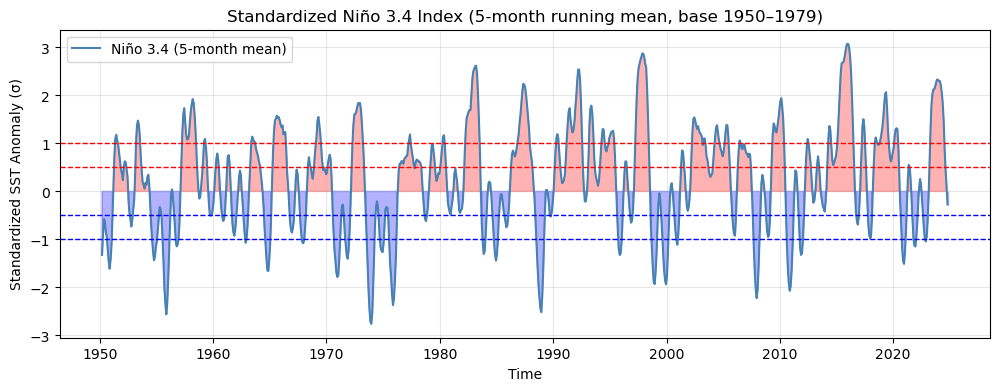

In [27]:
plt.figure(figsize=(12,4))
nino34_std.plot(color="steelblue", lw=1.5, label="Niño 3.4 (5-month mean)")
plt.axhline(0.5, color="r", ls="--", lw=1)
plt.axhline(1.0, color="r", ls="--", lw=1)
plt.axhline(-0.5, color="b", ls="--", lw=1)
plt.axhline(-1.0, color="b", ls="--", lw=1)
plt.fill_between(nino34_std["time"], 0, nino34_std,
                 where=nino34_std > 0, color="red", alpha=0.3)
plt.fill_between(nino34_std["time"], 0, nino34_std,
                 where=nino34_std < 0, color="blue", alpha=0.3)
plt.title("Standardized Niño 3.4 Index (5-month running mean, base 1950–1979)")
plt.ylabel("Standardized SST Anomaly (σ)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Congratulations! You have plotted the Nino 3.4 index. 

Based on the plot above, is the 1997-1998 still the strongest El Niño event? If you want, you can try calculating and plotting other El Niño events in additional cells below. 

---
### Part 8. PCA of Tropical Pacific SST: Setting up the Problem

Now we will perform a principal component analysis (PCA) on the tropical Pacific SST. Our goal is to see if we can recreate the Niño 3.4 Index time series above through PCA. 

Before we do the PCA, we will take a look at the spatial structure of the data. Let’s pick a larger region so that we can more easily see what is going on.

In [28]:
sst_pac = sst.sel(time=slice("1950", "2020"),
                  lat=slice(-30, 30),
                  lon=slice(120, 300))

The output of PCA is a set of pairs of spatial patterns (EOFs) and time series (PCs). The size of the set depends on the size of the original data. The pairs are ordered in terms of variance explained, i.e. the first pair explains the largest fraction of variance in the data, the second pair explains the second largest fraction of variance, and so on.

If we leave the seasonal cycle in our data, the seasonal cycle will likely emerge as the largest source of variance. Let’s see if this is what we get.

First, we will compute an anomaly. We will NOT subtract a monthly climatology (we want to see the seasonal cycle emerge from our analysis) - instead just subtract the time mean.

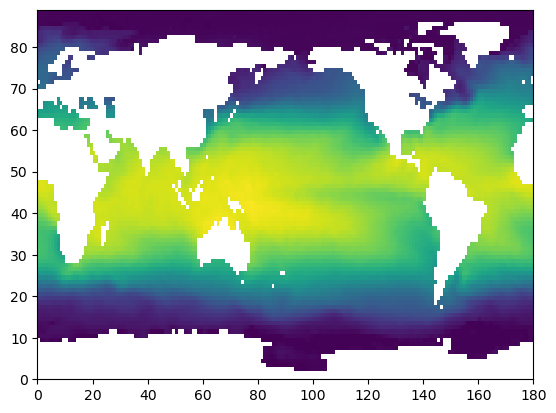

In [29]:
plt.pcolormesh(sst[-1])

In [30]:
# (a) Remove only the time mean
ssta_pac = sst_pac - sst_pac.mean(dim="time")

In [68]:
ssta_pac

<xarray.DataArray 'sst' (time: 852, lat: 31, lon: 91)> Size: 10MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-4.202389  , -3.8553638 , -3.3456135 , ..., -2.40691   ,
         -2.5953274 , -2.768755  ],
        [        nan, -5.2158165 , -4.439644  , ..., -2.2310123 ,
         -2.4717712 , -2.669365  ],
        [        nan, -5.261014  , -4.569063  , ..., -2.0240803 ,
         -2.2185345 , -2.4689426 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.06758118,  0.2536621 ,  0.5891266 , ...,  0.85562134,
          0.8958931 ,  0.9168701 ],
        [        nan,  1.1803932 ,  0.86727715, ...,  0.95175743,
          0.9047661 ,  0.9181595 ],
        [        nan,  1.8779373 ,  1.3423042 , ...,  1.1362133 ,
          1.1073322 ,  1.1167488 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-2.4607735 , -2.2336483 , -1.4345741 , ..., -0.56513405,
         -0.4253788 , -0.19524384],
        [        nan, -1.7415409 , -1.2934055 , ..., -0.68902206,
         -0.64780617, -0.46039963],
        [        nan, -1.598608  , -0.9547844 , ..., -0.60484886,
         -0.5420742 , -0.44446564]]], shape=(852, 31, 91), dtype=float32)
Coordinates:
  * lat      (lat) float64 248B -30.0 -28.0 -26.0 -24.0 ... 24.0 26.0 28.0 30.0
    lev      float64 8B 0.0
  * lon      (lon) float64 728B 120.0 122.0 124.0 126.0 ... 296.0 298.0 300.0
  * time     (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2020-12-15

To visualize these anomalies, we can plot the data on a map by slicing just one one element in time.

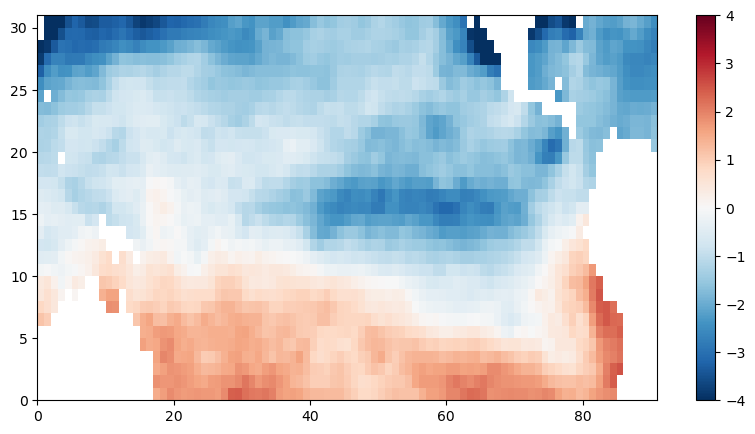

In [31]:
plt.figure(figsize=(10,5))
plt.pcolormesh(ssta_pac[0],cmap = "RdBu_r", )
plt.clim(-4,4)
plt.colorbar()
plt.show()

If we do remove the monthly climatology, how does the above anomaly plot change?

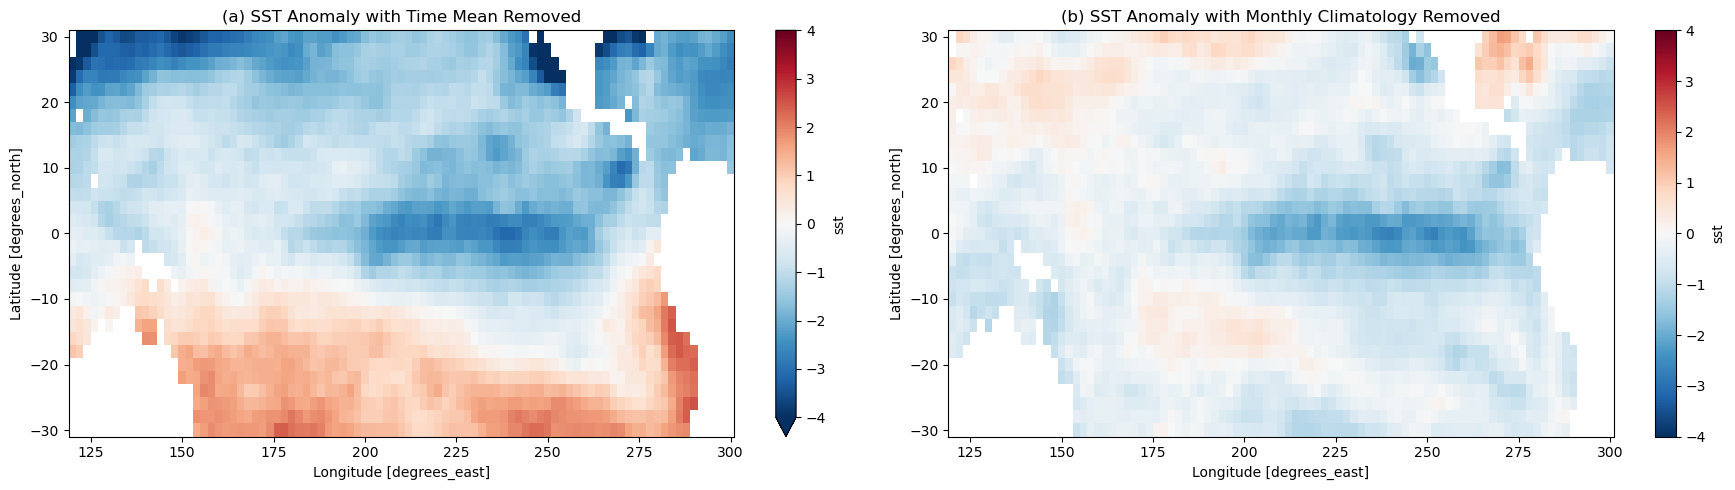

In [32]:
# (1) Remove overall time mean — keep seasonal cycle
ssta_pac = sst_pac - sst_pac.mean(dim="time")

# (2) Remove monthly climatology — remove seasonal cycle
sst_clim_monthly = sst_pac.groupby("time.month").mean(dim="time")
ssta_pac_noseason = sst_pac.groupby("time.month") - sst_clim_monthly

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
ssta_pac.isel(time=0).plot(cmap="RdBu_r", vmin=-4, vmax=4)
plt.title("(a) SST Anomaly with Time Mean Removed")

plt.subplot(1,2,2)
ssta_pac_noseason.isel(time=0).plot(cmap="RdBu_r", vmin=-4, vmax=4)
plt.title("(b) SST Anomaly with Monthly Climatology Removed")

plt.tight_layout()
plt.show()


We see some similar features between the two plots, but we also see that the warm southern hemisphere and the cold northern hemisphere is reduced, suggesting that this part of the pattern is associated with the seasonal cycle.

When we subtract the time mean, we remove the global offset but the repeating annual cycle remains.

When we subtract the monthly climatology, we remove the seasonal cycle itself — leaving behind year-to-year anomalies like El Niño and La Niña.
This step is crucial because PCA identifies dominant patterns of variance, and if we don’t remove the seasonal cycle, it will dominate the first EOF.

PCA should identify sources of variance, so a good place to start to explore the variance in our data is to plot the standard deviation for each grid point.

We can plot the standard deviation on a map. 

When we only remove the overall mean, the largest SST variability appears in the mid-latitudes — that’s mostly the seasonal cycle.

But when we remove the monthly climatology, the remaining variability shifts to the tropical Pacific, where ENSO dominates.

C:\Users\alexg\miniconda3\envs\meteo203\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexg\miniconda3\envs\meteo203\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


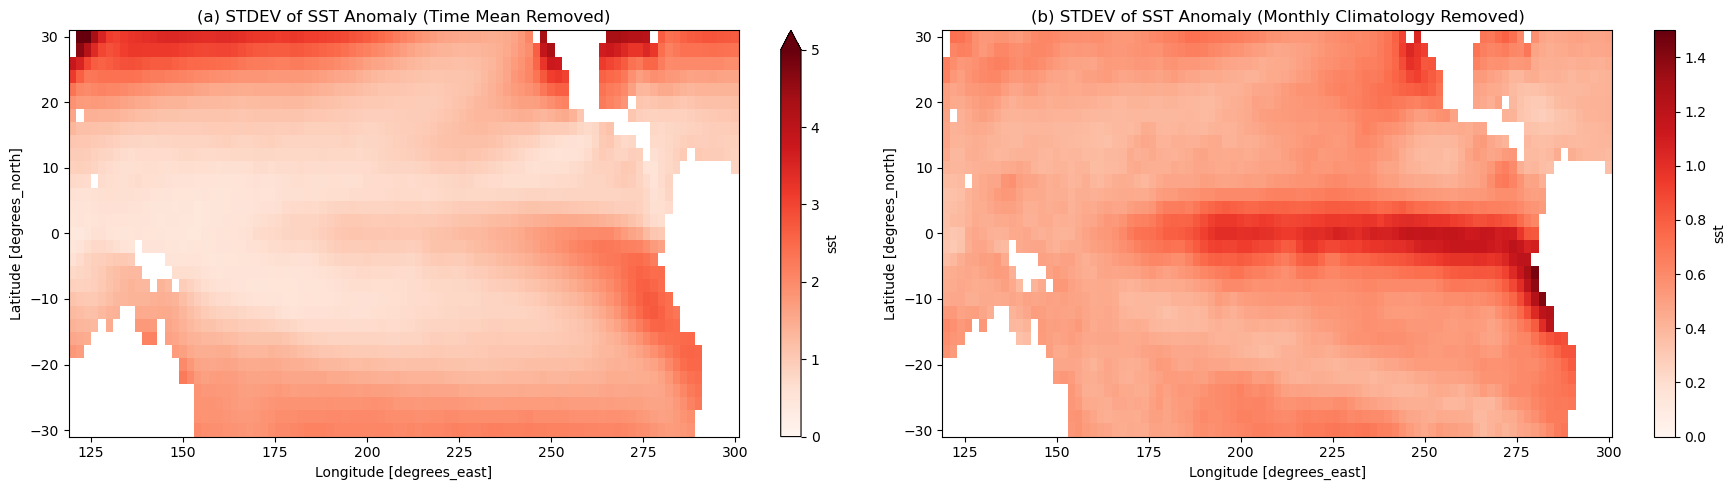

In [33]:
# Compute spatial standard deviation maps
ssta_pac_std = ssta_pac.std(dim="time")
ssta_pac_std_noseason = ssta_pac_noseason.std(dim="time")

# Visualize side by side
plt.figure(figsize=(18,5))

# (a) Time-mean removed (seasonal cycle retained)
plt.subplot(1,2,1)
ssta_pac_std.plot(cmap="Reds", vmin=0, vmax=5, add_colorbar=True)
plt.title("(a) STDEV of SST Anomaly (Time Mean Removed)")

# (b) Monthly climatology removed (seasonal cycle removed)
plt.subplot(1,2,2)
ssta_pac_std_noseason.plot(cmap="Reds", vmin=0, vmax=1.5, add_colorbar=True)
plt.title("(b) STDEV of SST Anomaly (Monthly Climatology Removed)")

plt.tight_layout()
plt.show()

We can then also plot this in a cartopy map


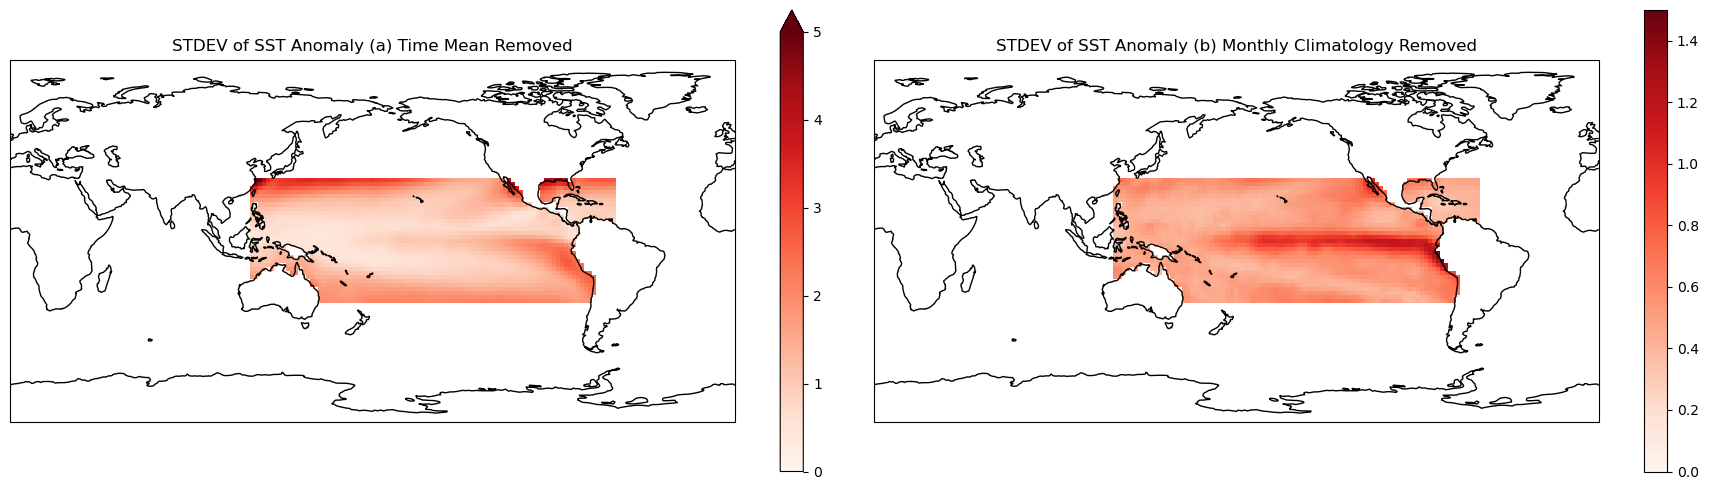

In [34]:
proj = ccrs.PlateCarree(central_longitude=180)

fig, axs = plt.subplots(1, 2, figsize=(18,5), subplot_kw={'projection': proj})

for ax, field, title, vmax in zip(
    axs,
    [ssta_pac_std, ssta_pac_std_noseason],
    ["(a) Time Mean Removed", "(b) Monthly Climatology Removed"],
    [5, 1.5]
):
    field.plot.pcolormesh(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap="Reds", vmin=0, vmax=vmax,
        add_colorbar=True, add_labels=False
    )
    ax.coastlines()
    ax.set_global()
    ax.set_title(f"STDEV of SST Anomaly {title}")

plt.tight_layout()
plt.show()


### Part 9. PCA: Step-by-step

In this section we will calculate the PCA using the provided steps below. For a very brief overview, you can take a look at a brief summary of calculating the PCA [here](https://medium.com/analytics-vidhya/understanding-principle-component-analysis-pca-step-by-step-e7a4bb4031d9). Take note that the aforementioned article calculates PCA for 2 dimensions, while we will be calculating for 3 dimensions (which we will be reducing to 2). 

In summary, the steps are as follows:
1. Clean the data by filling in missing values
2. Standardize the data
3. Convert from 3D to 2D
4. Calculate the [covariance matrix](https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc541.htm)
5. Perform [eigenanalysis](https://online.stat.psu.edu/stat505/lesson/4/4.5) for the covariance matrix
6. Extract and standardize the first two [Empirical Orthogonal Functions or EOF](https://climatedataguide.ucar.edu/climate-tools/empirical-orthogonal-function-eof-analysis-and-rotated-eof-analysis)
7. Plot EOF1 (seasonal cycle), plot EOF2 (what other pattern emerges).

#### Step 1: Fill in missing values
This step is important since some matrix calculations will fail if some values are missing.

In [35]:
a = ssta_pac.fillna(0)

In [67]:
a

<xarray.DataArray 'sst' (time: 852, lat: 31, lon: 91)> Size: 10MB
array([[[ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        [ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        [ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        ...,
        [-2.9949467e+00, -2.7476299e+00, -2.3843424e+00, ...,
         -1.7153498e+00, -1.8496306e+00, -1.9732285e+00],
        [ 1.1980867e-07, -3.7171936e+00, -3.1640332e+00, ...,
         -1.5899916e+00, -1.7615749e+00, -1.9023955e+00],
        [ 1.1980867e-07, -3.7494049e+00, -3.2562673e+00, ...,
         -1.4425157e+00, -1.5810988e+00, -1.7595590e+00]],

       [[ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        [ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        [ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
...
          6.0978198e-01,  6.3848275e-01,  6.5343261e-01],
        [ 1.1980867e-07,  8.4123945e-01,  6.1808878e-01, ...,
          6.7829597e-01,  6.4480633e-01,  6.5435147e-01],
        [ 1.1980867e-07,  1.3383633e+00,  9.5662975e-01, ...,
          8.0975342e-01,  7.8917056e-01,  7.9588151e-01]],

       [[ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        [ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        [ 1.1980867e-07,  1.1980867e-07,  1.1980867e-07, ...,
          1.1980867e-07,  1.1980867e-07,  1.1980867e-07],
        ...,
        [-1.7537371e+00, -1.5918701e+00, -1.0223882e+00, ...,
         -4.0275803e-01, -3.0315766e-01, -1.3914572e-01],
        [ 1.1980867e-07, -1.2411565e+00, -9.2178059e-01, ...,
         -4.9105021e-01, -4.6167657e-01, -3.2811621e-01],
        [ 1.1980867e-07, -1.1392914e+00, -6.8045294e-01, ...,
         -4.3106189e-01, -3.8632381e-01, -3.1676042e-01]]],
      shape=(852, 31, 91), dtype=float32)
Coordinates:
  * lat      (lat) float64 248B -30.0 -28.0 -26.0 -24.0 ... 24.0 26.0 28.0 30.0
    lev      float64 8B 0.0
  * lon      (lon) float64 728B 120.0 122.0 124.0 126.0 ... 296.0 298.0 300.0
  * time     (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2020-12-15

#### Step 2: Standardize Data

In [36]:
a = (a - a.mean()) / a.std()
print(a.mean(), a.std())

<xarray.DataArray 'sst' ()> Size: 4B
array(9.5863735e-09, dtype=float32)
Coordinates:
    lev      float64 8B 0.0 <xarray.DataArray 'sst' ()> Size: 4B
array(1.0000001, dtype=float32)
Coordinates:
    lev      float64 8B 0.0


#### Step 3: Convert 3D array to 2D matrix

The next step is to convert our 3D array into a 2D matrix, so that we can perform matrix operations. We do this by combining all the spatial dimensions together.

First, let's check the shape of the data.

In [37]:
a.shape

(852, 31, 91)

We have a 3-D array (time, latitude, longitude). We need to convert it to 2-D.  So, we combine the two spatial dimensions (latitude and longitude) into one by reshaping the arrays. Think of this as compressing or squeezing in the multidimensional data (time, lat, lon) into two dimensions (time, latlon).


In [38]:

# Reshape the array to have one time dimension, one space dimension

Nt, Ny, Nx = a.sizes["time"], a.sizes["lat"], a.sizes["lon"]
A = a.values.reshape(Nt, Ny * Nx)

Check the shape of the combined data (`A.shape`).

In [39]:
A.shape

(852, 2821)

#### Step 4: Calculate covariance matrix
Now, we can calculate the [covariance matrix](https://numpy.org/doc/2.3/reference/generated/numpy.cov.html). Since our data is standardized, we will actually be computing the correlation matrix.

Similar to the correlation matrix in Exercise 5, we are calculating for how similar (or different) are the SST observations in pairs of time and combined space. We won't be plotting the heatmap this time since this will be a correlation matrix for 2,821 pairs of data.

In [40]:
C = np.cov(A, rowvar=False)
print(C.shape)

(2821, 2821)


#### Step 5: Perform eigenanalysis of covariance matrix

Eigenanalysis finds the principal directions of *variability* in the covariance matrix - the axes along which the data vary the most.

In PCA, these directions are called the [*eigenvectors* (the spatial patterns or EOFs)](https://math.libretexts.org/Bookshelves/Linear_Algebra/A_First_Course_in_Linear_Algebra_(Kuttler)/07%3A_Spectral_Theory/7.01%3A_Eigenvalues_and_Eigenvectors_of_a_Matrix). Their corresponding *eigenvalues* tell us how much variance each mode explains.

In other words, Eigenvectors show the main directions of variability (the patterns), and eigenvalues tell how important each one is.

We can calculate these using [`np.linalg.eig()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html#scipy.linalg.eig), where the expected outputs are the Eigenvalues and the Eigenvectors.

In [41]:
eigvals, eigvecs = np.linalg.eig(C)

The output of the eigenanalysis is a set of spatial patterns (EOFs). For the code above,

- `eigvals` → a list of numbers (one per mode) that tell us how much variance each eigenvector explains.
    - Larger eigenvalues → more important patterns.

- `eigvecs` → a set of vectors that show the directions or patterns of variability (in PCA, these become the EOFs).
    - Each column of `eigvecs` corresponds to one spatial pattern (one EOF).
    - Together with the time series they produce (the PCs), they describe how the data varies in space and time.

In short: `eigvals` tell us how much, and `eigvecs` tell us where and how the data vary.

We can try printing the `eigvals` array to show how important each principal component (PC) is. The magnitude of each element shows the *relative importance* of each PC (i.e. the first element corresponds to PC 1 (the dominant mode), the second to PC 2, and so on.).

In [42]:
eigvals

array([2216.57599915+0.j,  248.59717402+0.j,   92.69834935+0.j, ...,
          0.        +0.j,    0.        +0.j,    0.        +0.j],
      shape=(2821,))

The companion array `eigvecs` contains the spatial patterns (directions) associated with each PC.

Each **column** of `eigvecs` represents one eigenvector — the **pattern of weights** that defines how different grid points vary together to form that PC. 

Check the shape of `eigvecs` below.

In [43]:
eigvecs.shape

(2821, 2821)

The eigenvectors (`eigvecs`) are returned by NumPy as columns of a 2-D array, where each column corresponds to one principal component (PC), and each row corresponds to one grid point (a specific latitude–longitude location) in our dataset.

When we prepared our data for PCA, we *flattened the spatial dimensions* (lat × lon) into a single “space” dimension —
so each grid cell’s SST time series became *one row* in our covariance matrix.

In the next step, we’ll reshape these eigenvectors back into latitude–longitude maps to visualize the EOF spatial patterns.

#### Step 6: Extract and standardize the first two EOFs and PCs

The eigenvectors from the covariance matrix can also be called Empirical Orthogonal Functions (EOFs) in climate science.

Each EOF represents a spatial pattern that explains a particular fraction of variance in the dataset —
in our case, patterns of SST variability across the tropical Pacific.
- EOF 1 corresponds to the spatial pattern of the dominant mode (usually the seasonal cycle).
- EOF 2 often represents the next major mode (for SST, this is the ENSO pattern).

The term “Empirical” reflects that these patterns are derived from data, not theoretical equations — they are the data’s own preferred modes of variability.


Each EOF is a spatial pattern (the “where” of variability), and each PC is its time series (the “when”).
EOF1 and EOF2 are ordered by how much variance they explain — EOF1 explains the most, EOF2 the next.

To visualize an eigenvector (now an EOF) as a map again, we need to reshape it back from this flattened 1-D form into its original 2-D grid shape (Ny × Nx):

For example, in the code below
```python
EOF1 = np.real(eigvecs[:, 0]).reshape(Ny, Nx)
```
- `eigvecs[:, 0]` → takes the first eigenvector (corresponding to EOF 1)

- `.reshape(Ny, Nx)` → restores its 2-D structure so we can plot it on latitude–longitude coordinates




In [51]:
# --- Extract first two EOF spatial patterns (eigenvectors reshaped to lat-lon grid) ---
EOF1 = np.real(eigvecs[:, 0]).reshape(Ny, Nx)
EOF2 = np.real(eigvecs[:, 1]).reshape(Ny, Nx)
EOF3 = np.real(eigvecs[:, 2]).reshape(Ny, Nx)

After extracting the EOFs (the spatial patterns), we can find the corresponding Principal Components (PCs), the time series that tell us how strongly each pattern is expressed at each time step.

Mathematically, this is done using the dot product:

```python
PC1 = np.dot(A, np.real(eigvecs[:, 0]))
```

The dot product multiplies each grid point’s SST anomaly by its weight from the EOF pattern, then sums over all grid points. In other words, it projects the full SST field at each time step onto the EOF — telling us *“how much of that spatial pattern is present in the data at that moment."*

- `A` → SST anomaly data flattened into (time × space) form
- `eigvecs[:, 0]` → EOF 1 (spatial weights for each grid point)
- `np.dot(A, eigvecs[:, 0])` → multiplies each SST field by its weights → gives one value per time step (the PC time series)

Thus, the dot product converts spatial information (EOF) into temporal behavior (PC).

In [52]:
# --- Compute corresponding principal component (PC) time series ---
PC1 = np.dot(A, np.real(eigvecs[:, 0]))
PC2 = np.dot(A, np.real(eigvecs[:, 1]))
PC3 = np.dot(A, np.real(eigvecs[:, 2]))



After computing each Principal Component (PC) time series, we standardize them so they have a mean of 0 and a standard deviation of 1.

This step removes any offset or scale differences between components, making them directly comparable in amplitude and variability.

In [53]:
# --- Standardize the PCs to zero mean and unit variance ---
PC1 = (PC1 - PC1.mean()) / PC1.std()
PC2 = (PC2 - PC2.mean()) / PC2.std()
PC3 = (PC3 - PC3.mean()) / PC3.std()

#### Step 7. Plot EOF1 and PC1 (Seasonal Cycle mode)
- EOF 1 shows north–south temperature contrast: warm Southern Hemisphere vs cool Northern Hemisphere.
- PC 1 oscillates annually → this is the seasonal cycle emerging purely from statistics.
- PCA has identified the largest repeating pattern in the data — the annual temperature swing.

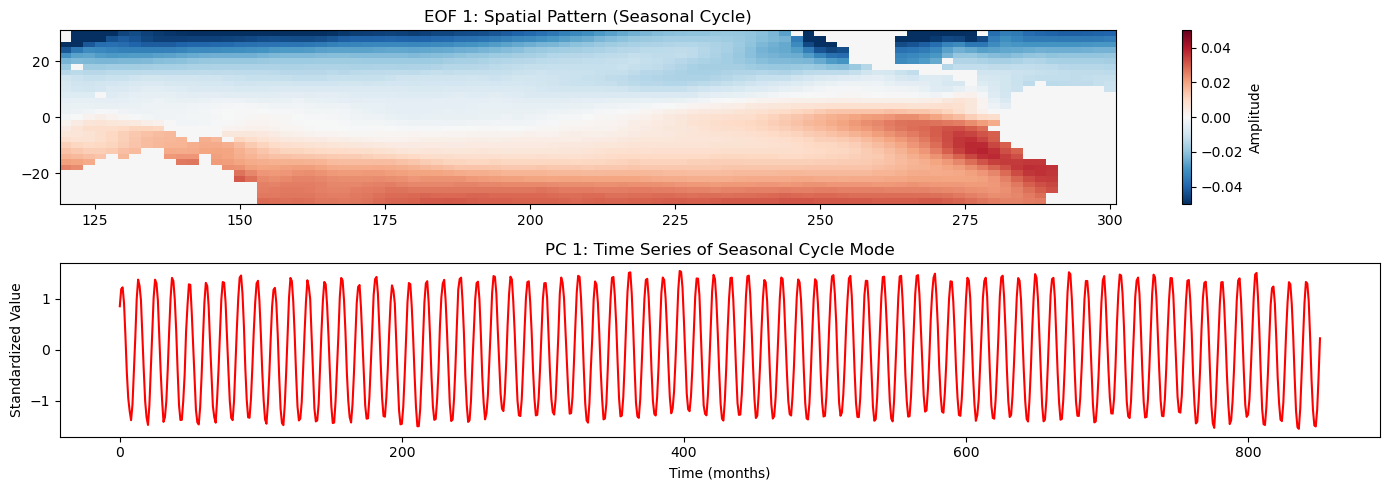

In [47]:
plt.figure(figsize=(14,5))

# EOF 1 spatial pattern
plt.subplot(2,1,1)
plt.pcolormesh(a.lon, a.lat, EOF1, cmap="RdBu_r", vmin=-0.05, vmax=0.05)
plt.colorbar(label="Amplitude")
plt.title("EOF 1: Spatial Pattern (Seasonal Cycle)")

# PC 1 time series
plt.subplot(2,1,2)
plt.plot(PC1, color="r")
plt.title("PC 1: Time Series of Seasonal Cycle Mode")
plt.xlabel("Time (months)")
plt.ylabel("Standardized Value")
plt.tight_layout()
plt.show()


#### Step 8. Plot EOF 2 and PC 2 (ENSO / El Niño–La Niña Mode)
- EOF 2 shows the El Niño pattern —  warm anomalies in the central/eastern Pacific, cool anomalies in the west.
- PC 2 behaves similarly to the Niño 3.4 index (ENSO time series).
- Positive PC 2 → El Niño; Negative PC 2 → La Niña.
- PCA “discovered” ENSO without being told about it — that’s the power of statistical decomposition.

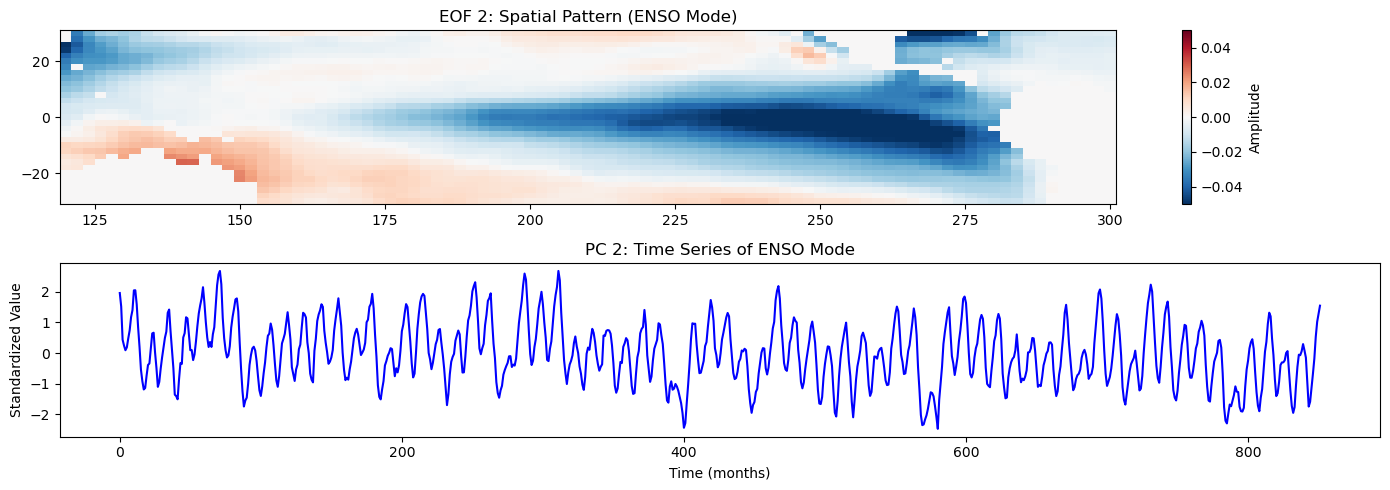

In [48]:
plt.figure(figsize=(14,5))

# EOF 2 spatial pattern
plt.subplot(2,1,1)
plt.pcolormesh(a.lon, a.lat, EOF2, cmap="RdBu_r", vmin=-0.05, vmax=0.05)
plt.colorbar(label="Amplitude")
plt.title("EOF 2: Spatial Pattern (ENSO Mode)")

# PC 2 time series
plt.subplot(2,1,2)
plt.plot(PC2, color="b")
plt.title("PC 2: Time Series of ENSO Mode")
plt.xlabel("Time (months)")
plt.ylabel("Standardized Value")
plt.tight_layout()
plt.show()


#### Step 9 - Interpreting and Adjusting the Sign of EOFs

When performing Principal Component Analysis (PCA) or Empirical Orthogonal Function (EOF) analysis,
the resulting spatial patterns (EOFs) and corresponding time series (PCs) are unique only up to a sign.

Mathematically, both of these are valid solutions: (EOF,PC) and (−EOF,−PC)

This means that sometimes your EOF 2 map might appear “flipped” — for example, mostly blue when you expected red — because PCA does not assign physical meaning to “positive” or “negative”.

What matters are:
- the pattern of variability (warm vs. cool regions), and
- how that pattern co-varies with its time series.

To make the EOF interpretation consistent with known climate indices (e.g., Niño 3.4),
we usually flip the sign so that positive PC values correspond to El Niño (warm eastern Pacific)
and negative PC values correspond to La Niña (cool eastern Pacific).

Because PCA’s sign is arbitrary, we compare PC2 with the Niño 3.4 index and flip the sign if they’re anticorrelated (i.e. if they're inverted).
Here we used the overlapping 1950–2020 period, dropped missing values, and ensured both arrays had the same length before computing the correlation.

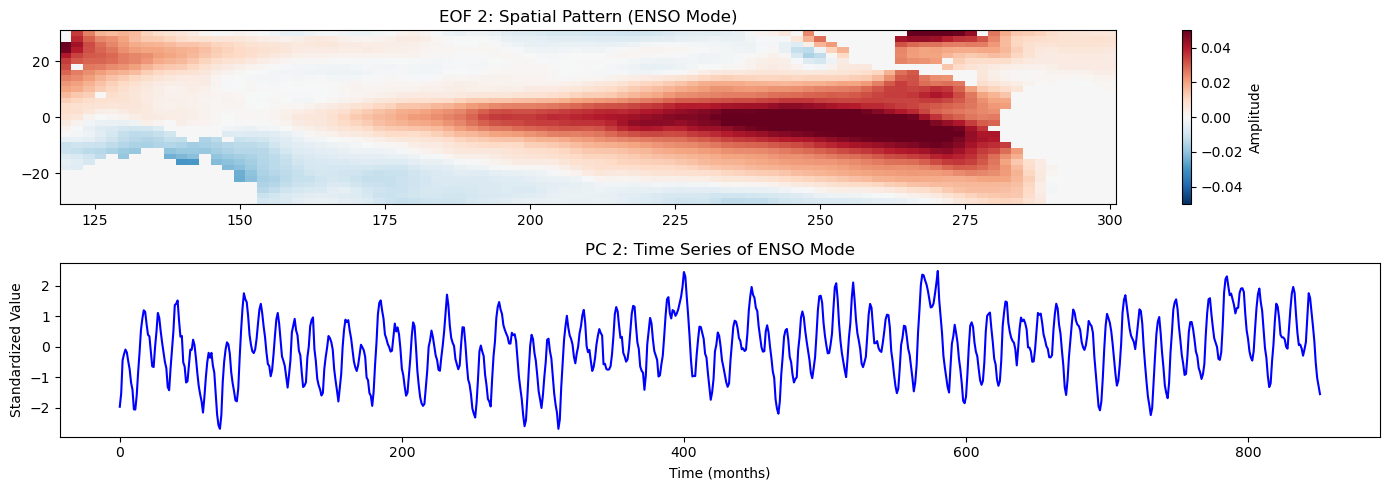

In [49]:
plt.figure(figsize=(14,5))

# EOF 2 spatial pattern
plt.subplot(2,1,1)
# Take note of the negative sign before EOF2
plt.pcolormesh(a.lon, a.lat, -EOF2, cmap="RdBu_r", vmin=-0.05, vmax=0.05)
plt.colorbar(label="Amplitude")
plt.title("EOF 2: Spatial Pattern (ENSO Mode)")

# PC 2 time series
plt.subplot(2,1,2)
# Take note of the negative sign before PC2
plt.plot(-PC2, color="b")
plt.title("PC 2: Time Series of ENSO Mode")
plt.xlabel("Time (months)")
plt.ylabel("Standardized Value")
plt.tight_layout()
plt.show()


#### Step 10 - Comparing the PCA-Derived ENSO Mode with the Niño 3.4 Index

In the final step, we compare the second principal component (PC2) from our EOF analysis with the Niño 3.4 Index that we computed earlier from the SST anomalies.

Both describe the same underlying phenomenon — the El Niño–Southern Oscillation (ENSO) — but they are derived in very different ways:

- Niño 3.4 Index: a regional average of SST anomalies within 5° S–5° N and 170° W–120° W It’s a physically defined measure based on a fixed geographic box.
- PC 2: a statistical mode obtained through Principal Component Analysis of the entire tropical Pacific SST field. PCA identifies patterns that explain the largest fractions of variance, without any prior knowledge of ENSO.

By aligning their time periods and flipping the EOF 2/PC2 signs if needed, we find that these two time series are strongly correlated (typically r ≈ 0.7–0.9).

This strong agreement shows that PCA objectively “rediscovers” ENSO as the second dominant mode of tropical Pacific variability, right after the seasonal cycle.

Correlation between Niño 3.4 index and PC 2 = 0.62


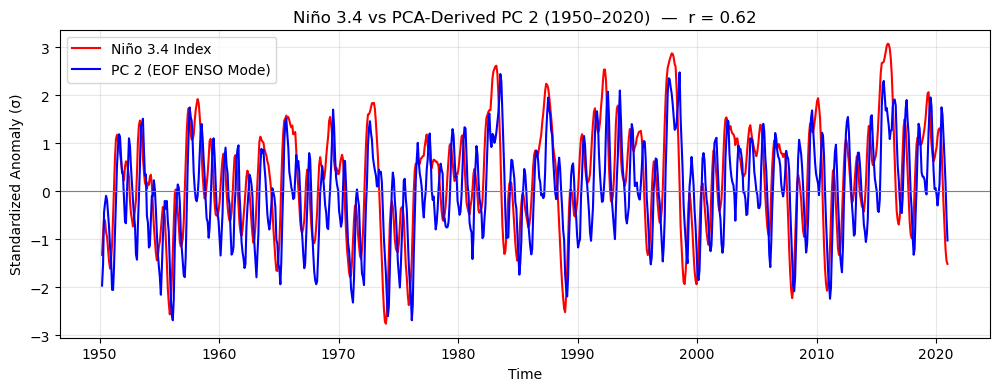

In [50]:
# Flip the sign of PC2
PC2_fl = -PC2

# Select overlapping period
nino34_sub = nino34_std.sel(time=slice("1950", "2020"))

# Drop NaNs (from running mean)
nino34_sub = nino34_sub.dropna("time")

# Match lengths
minlen = min(len(PC2_fl), len(nino34_sub))
pc2_aligned = PC2_fl[:minlen]
nino34_aligned = nino34_sub.values[:minlen]
time_aligned = nino34_sub.time[:minlen]

corr = np.corrcoef(pc2_aligned, nino34_aligned)[0, 1]
print(f"Correlation between Niño 3.4 index and PC 2 = {corr:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(time_aligned, nino34_aligned, color="r", label="Niño 3.4 Index")
plt.plot(time_aligned, pc2_aligned, color="b", label="PC 2 (EOF ENSO Mode)")
plt.axhline(0, color="gray", lw=0.8)
plt.legend()
plt.title(f"Niño 3.4 vs PCA-Derived PC 2 (1950–2020)  —  r = {corr:.2f}")
plt.ylabel("Standardized Anomaly (σ)")
plt.xlabel("Time")
plt.grid(alpha=0.3)
plt.show()


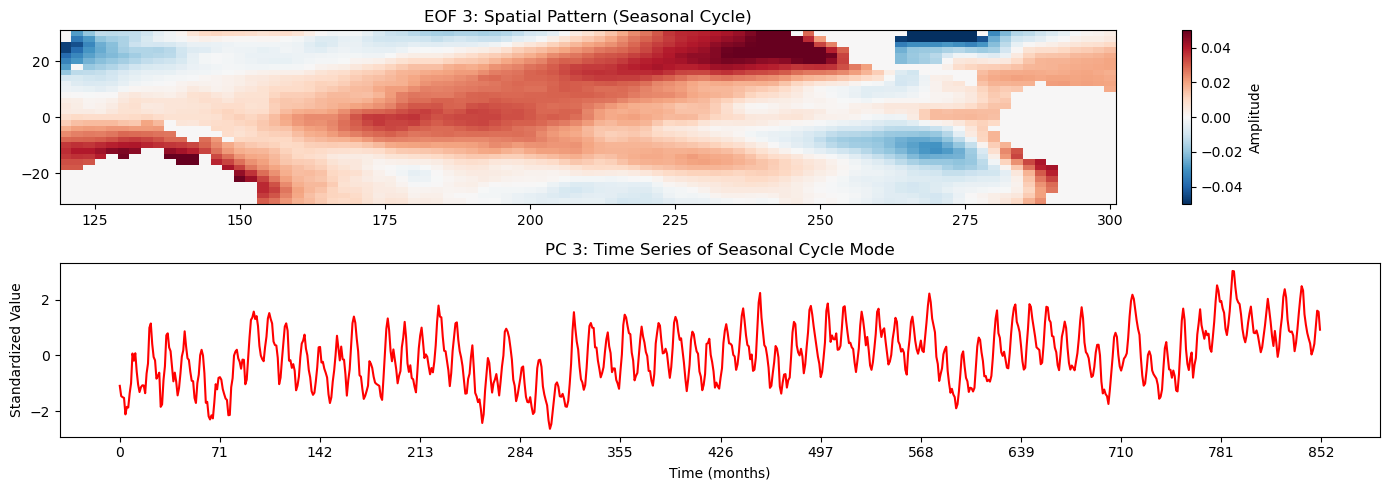

In [66]:
plt.figure(figsize=(14,5))

# EOF 3 spatial pattern
plt.subplot(2,1,1)
plt.pcolormesh(a.lon, a.lat, EOF3, cmap="RdBu_r", vmin=-0.05, vmax=0.05)
plt.colorbar(label="Amplitude")
plt.title("EOF 3: Spatial Pattern (Seasonal Cycle)")

# PC 3 time series
plt.subplot(2,1,2)
plt.plot(PC3, color="r")
plt.title("PC 3: Time Series of Seasonal Cycle Mode")
plt.xlabel("Time (months)")
x_points = np.linspace(0, 852, 13)
plt.xticks(x_points)
plt.ylabel("Standardized Value")
plt.tight_layout()
plt.show()


In [63]:
PC3

array([-1.09573176e+00, -1.46284756e+00, -1.50230234e+00, -1.52859086e+00,
       -2.11863609e+00, -1.84945503e+00, -1.87204956e+00, -1.36701549e+00,
       -9.99134725e-01,  6.42025534e-02, -1.94585899e-01,  7.30553978e-02,
       -5.84943746e-01, -1.04899007e+00, -1.31853937e+00, -1.14495968e+00,
       -1.07799374e+00, -1.08193750e+00, -1.35954918e+00, -6.55266240e-01,
       -2.93393985e-01,  9.88007329e-01,  1.14094480e+00,  4.02926835e-01,
       -6.23229741e-02, -1.81518456e-01, -8.38748407e-01, -7.40600826e-01,
       -6.23268330e-01, -1.84864751e+00, -1.76166934e+00, -8.85678090e-01,
       -3.97110409e-01,  7.17896916e-01,  7.87131226e-01,  2.79343673e-01,
        1.47967865e-01, -4.12746692e-01, -9.34282245e-01, -6.22026824e-01,
       -9.46349960e-01, -1.43770746e+00, -1.17805645e+00, -6.55745838e-01,
       -4.53286840e-02,  1.75725912e-01,  8.59323999e-01,  3.20585013e-01,
       -1.03442855e-01, -1.68245775e-01, -5.90209917e-01, -9.13137362e-01,
       -9.29878637e-01, -

---

### PCA and FFT

Both PCA and FFT are decomposition techniques—but they answer different scientific questions.

| Feature             | **PCA / EOF Analysis**                                     | **FFT / Spectral Analysis**                            |
| ------------------- | ---------------------------------------------------------- | ------------------------------------------------------ |
| **Goal**            | Find dominant *spatial* or *covariance* patterns           | Find dominant *temporal* frequencies                   |
| **Basis functions** | Data-derived empirical patterns (EOFs)                     | Fixed sine + cosine waves                              |
| **Input**           | Multivariate fields (lat × lon × time)                     | Single or multivariate time series                     |
| **Output**          | EOFs → spatial modes; PCs → time series                    | Amplitude & phase spectra vs. frequency                |
| **Assumptions**     | No assumption of periodicity; patterns emerge from data    | Assumes stationarity and periodicity                   |
| **Best for**        | Discovering climate modes (ENSO, NAO, monsoon variability) | Detecting cycles (annual, diurnal, 3-7 yr ENSO period) |

In essence:

- PCA decomposes variance in space + time.
- FFT decomposes variance in time + frequency.

Together, they complement each other:
PCA tells us what spatial patterns vary together, while FFT tells us how often those variations occur.